In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np

# ------------------ CONFIG IMPORT ----------------------
# Add project root to sys.path so config.py can be imported
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")

# Add both to PYTHON PATH
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
!python -m spacy download en_core_web_sm
from sentiment_analysis import add_sentiment_columns
from tfidf_keywords import extract_keywords_per_bank
from noun_extraction import extract_nouns, compute_noun_counts
from theme_builder import build_themes_per_bank, assign_theme

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 495.5 kB/s eta 0:00:26
     --------------------------------------- 0.0/12.8 MB 495.5 kB/s eta 0:00:26
     --------------------------------------- 0.0/12.8 MB 495.5 kB/s eta 0:00:26
     --------------------------------------- 0.1/12.8 MB 598.8 kB/s eta 0:00:22
     --------------------------------------- 0.1/12.8 MB 450.6 kB/s eta 0:00:29
     --------------------------------------- 0.2/12.8 MB 518.9 kB/s eta 0:00:25
      -------------------------------------- 0.2/12.8 MB 537.4 kB/s eta 0:00:24
      -------------------------------------- 0.2/12.8 MB 551.4 kB/s eta 0:00:23
      -------------------------------------- 0.3/12.8 MB 587.7 kB/s eta 0:00:22
      -------------------------------------- 0.3/12.8 MB 613.6 kB/s eta 0:00:21
     - ------------------------------------- 0.4/12.8 MB


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from config import DATA_PATHS
df = pd.read_csv(DATA_PATHS["processed_reviews"])
df.head()


,review_id,review_text,clean_text,tokens,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,843256e6-6275-4ae5-adaf-a01889b8a49f,Make the reason we wrote visible on app transa...,make reason wrote visible app transaction,"['make', 'reason', 'wrote', 'visible', 'app', ...",2,2025-12-01,2025,12,Abyssinia,Bank of Abyssinia,Abraham Wolde,0,52,Google Play
1,60e84fba-4730-499d-8f5b-88e52dda8db7,app is note active working crash,app note active working crash,"['app', 'note', 'active', 'working', 'crash']",1,2025-11-30,2025,11,Abyssinia,Bank of Abyssinia,BEKI Movie senter,0,32,Google Play
2,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,NaN,[],5,2025-11-29,2025,11,Abyssinia,Bank of Abyssinia,Yasin Alemu,0,2,Google Play
3,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,good,['good'],5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
4,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,goof,['goof'],5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play


In [3]:
df = add_sentiment_columns(df)
df[["review_text", "tb_sentiment", "vader_sentiment"]].head()



,review_text,tb_sentiment,vader_sentiment
0,Make the reason we wrote visible on app transa...,neutral,neutral
1,app is note active working crash,negative,neutral
2,🙏👍,neutral,neutral
3,Very Good,positive,positive
4,goof,neutral,neutral


TextBlob vs VADER

TextBlob polarity showed a smoother, more generalized scoring pattern.

VADER scores were more reactive to expressions of frustration (e.g., “crashing”, “not working”) and praise (e.g., “super app”, “good”, “fast”).

Both sentiment tools show a clear pattern:

5-star reviews → mostly positive sentiment

1–2-star reviews → mostly negative sentiment

3-star reviews → mapped to neutral or mixed polarity

This alignment suggests sentiment models are working correctly.


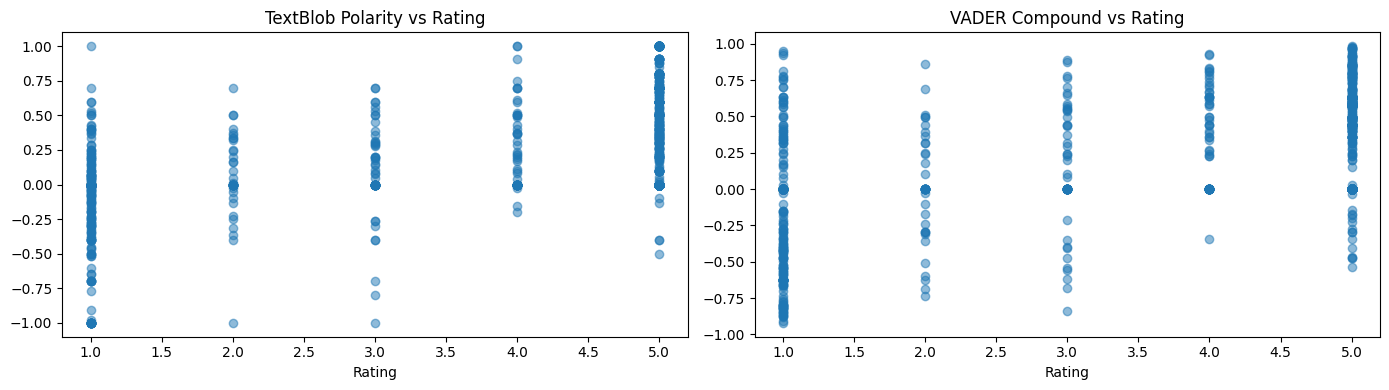

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].scatter(df["rating"], df["tb_polarity"], alpha=0.5)
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Rating")

axes[1].scatter(df["rating"], df["vader_compound"], alpha=0.5)
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Rating")

plt.tight_layout()
plt.show()


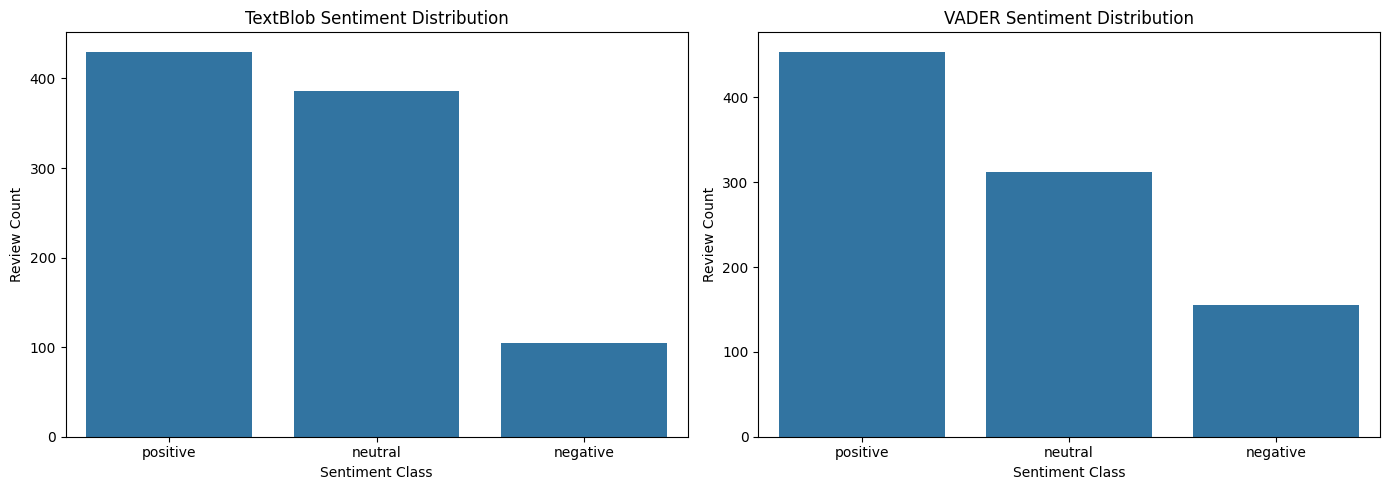

In [5]:
sentiment_cols = ["tb_sentiment", "vader_sentiment"]
titles = ["TextBlob Sentiment Distribution", "VADER Sentiment Distribution"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(sentiment_cols):
    sns.countplot(
        data=df,
        x=col,
        order=["positive", "neutral", "negative"],
        ax=axes[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sentiment Class")
    axes[i].set_ylabel("Review Count")

plt.tight_layout()
plt.show()

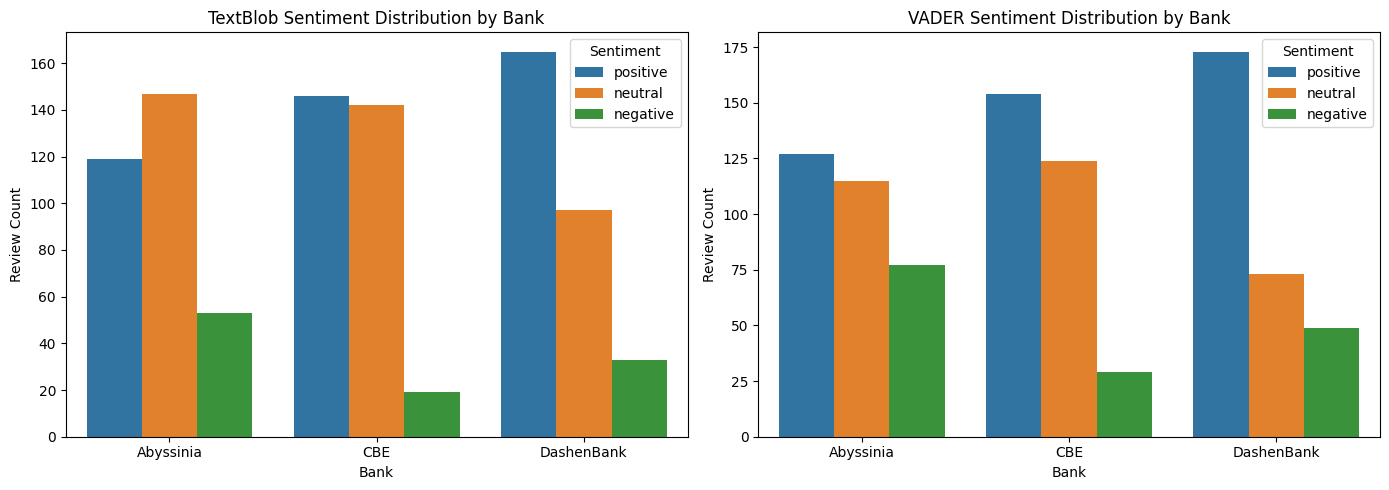

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(sentiment_cols):
    sns.countplot(
        data=df,
        x="bank_code",
        hue=col,
        order=df["bank_code"].unique(),
        hue_order=["positive", "neutral", "negative"],
        ax=axes[i]
    )
    axes[i].set_title(f"{titles[i]} by Bank")
    axes[i].set_xlabel("Bank")
    axes[i].set_ylabel("Review Count")
    axes[i].legend(title="Sentiment")

plt.tight_layout()
plt.show()


In [7]:
keywords_per_bank = extract_keywords_per_bank(df, top_n=30)

keywords_per_bank  # preview


{'Abyssinia': ['app',
  'good',
  'bank',
  'boa',
  'best',
  'working',
  'work',
  'worst',
  'banking',
  'mobile',
  'like',
  'doesn',
  'great',
  'use',
  'update',
  'fast',
  'time',
  'bad',
  'money',
  'banking app',
  'worst app',
  'doesn work',
  'good app',
  'application',
  'need',
  'mobile banking',
  'fix',
  'amazing',
  'experience',
  'better'],
 'CBE': ['app',
  'good',
  'best',
  'bank',
  'cbe',
  'like',
  'nice',
  'application',
  'best app',
  'good app',
  'update',
  'work',
  'love',
  'use',
  'banking',
  'excellent',
  'apps',
  'useful',
  'transfer',
  'money',
  'great',
  'service',
  'smart',
  'ethiopia',
  'doesn',
  'user',
  'friendly',
  'working',
  'mobile',
  'wow'],
 'DashenBank': ['app',
  'good',
  'bank',
  'best',
  'dashen',
  'super',
  'banking',
  'use',
  'amazing',
  'fast',
  'easy',
  'working',
  'dashen bank',
  'slow',
  'nice',
  'super app',
  'like',
  'excellent',
  'worst',
  'need',
  'time',
  'friendly',
  'gre

TF-IDF Keyword Extraction Observations
Per-bank keyword patterns emerged

CBE emphasized terms related to:

network, service, failure, balance, delay

Abyssinia focused heavily on:

otp, payment, option, service

Dashen highlighted:

crash, freeze, super app, update

These TF-IDF keywords capture recurring issues and feature requests specific to each bank.

However:

Many keywords were not included in the theme dictionary, which limited theme assignment accuracy later.

In [8]:
import json
keywords_path = os.path.join(os.path.dirname(DATA_PATHS["processed"]), "keywords.json")

with open(keywords_path, "w") as f:
    json.dump(keywords_per_bank, f, indent=2)

print("Saved:", keywords_path)


Saved: ../data\keywords.json


In [9]:
df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]].head()
noun_counts_by_bank = compute_noun_counts(df, top_n=50)
noun_counts_by_bank


{'Abyssinia': nouns
 app             108
 bank             33
 banking          20
 time             20
 money            17
 developer        16
 phone            14
 times            12
 options          12
 apps             11
 problem          10
 experience       10
 boa              10
 application      10
 😡                 9
 update            9
 issue             8
 service           8
 transaction       6
 bug               6
 account           6
 🇹                 5
 loading           5
 problems          5
 services          5
 number            5
 country           5
 point             5
 customers         4
 user              4
 👍                 4
 password          4
 security          4
 business          4
 banks             4
 days              3
 star              3
 features          3
 option            3
 transactions      3
 language          3
 code              3
 kind              3
 others            3
 page              3
 need              3
 device       

Most frequent nouns across banks included:

app

service

update

issue

otp

network

payment

error

device

option

problem

These nouns reveal:

Broad categories of usage problems

Missing services or features

Network and stability issues

Authentication-related challenges

BUT many of these nouns were NOT part of the predefined theme keyword lists, causing many reviews to be labeled as “Other”.

In [10]:
bank_themes = build_themes_per_bank(noun_counts_by_bank)
bank_themes


{'Abyssinia': {'Performance': ['app', 'update', 'bug'],
  'Login Issues': ['password'],
  'Transactions': ['transaction'],
  'UI/UX': [],
  'Network': [],
  'Customer Support': ['service'],
  'Other': ['bank',
   'banking',
   'time',
   'money',
   'developer',
   'phone',
   'times',
   'options',
   'apps',
   'problem',
   'experience',
   'boa',
   'application',
   '😡',
   'issue',
   'account',
   '🇹',
   'loading',
   'problems',
   'services',
   'number',
   'country',
   'point',
   'customers',
   'user',
   '👍',
   'security',
   'business',
   'banks',
   'days',
   'star',
   'features',
   'option',
   'transactions',
   'language',
   'code',
   'kind',
   'others',
   'page',
   'need',
   'device',
   'system',
   'work',
   'error']},
 'CBE': {'Performance': ['app', 'update'],
  'Login Issues': ['pin', 'password'],
  'Transactions': ['transaction', 'balance', 'transfer'],
  'UI/UX': ['button'],
  'Network': ['connection', 'internet'],
  'Customer Support': ['service

In [11]:
df["theme"] = df.apply(
    lambda row: assign_theme(row["bank_code"], row["nouns"], bank_themes),
    axis=1
)

df[["review_text", "nouns", "theme"]].head()


,review_text,nouns,theme
0,Make the reason we wrote visible on app transa...,"[reason, app, transaction]",Performance
1,app is note active working crash,"[working, crash]",Other
2,🙏👍,[],Other
3,Very Good,[],Other
4,goof,[goof],Other


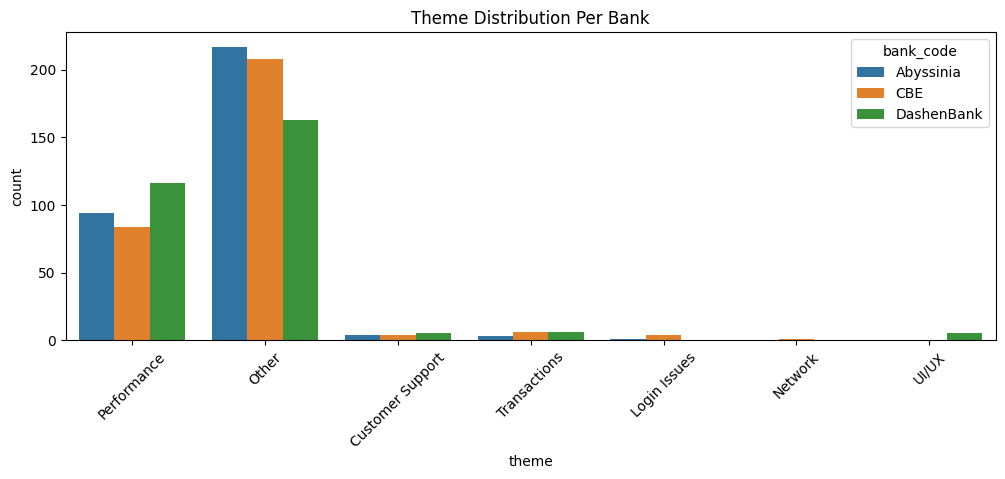

In [12]:

plt.figure(figsize=(12, 4))

sns.countplot(data=df, x="theme", hue="bank_code")
plt.title("Theme Distribution Per Bank")
plt.xticks(rotation=45)
plt.show()


In [13]:
from theme_builder2 import build_themes_from_tfidf, assign_theme_tfidf
bank_themes = build_themes_from_tfidf(keywords_per_bank)

# Assign themes
df["theme"] = df.apply(lambda row: assign_theme_tfidf(row, bank_themes), axis=1)

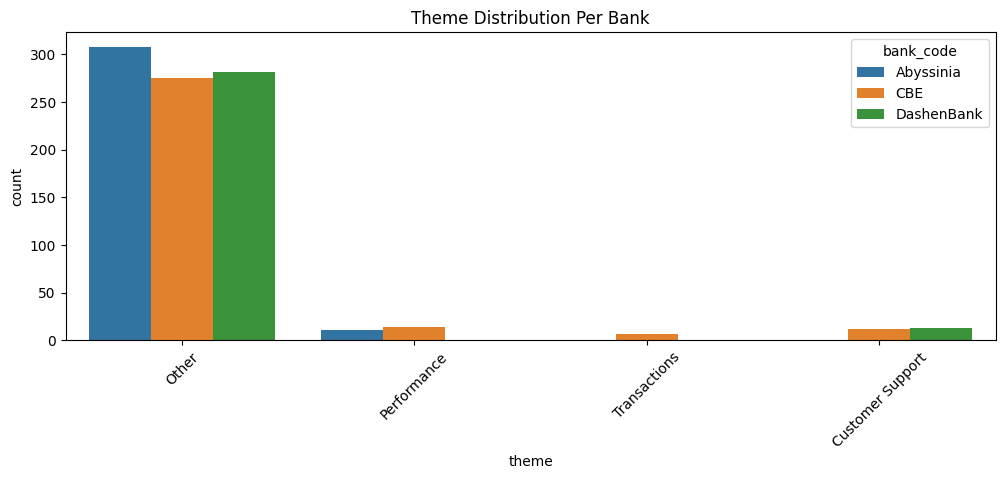

In [14]:
plt.figure(figsize=(12, 4))

sns.countplot(data=df, x="theme", hue="bank_code")
plt.title("Theme Distribution Per Bank")
plt.xticks(rotation=45)
plt.show()


In [15]:
from theme_builder3 import (
    build_bank_themes,
    assign_theme
)

# Step 1: Build themes from NEGATIVE review keywords
bank_themes = build_bank_themes(
    df,
    extract_keywords_func=extract_keywords_per_bank, # your TF-IDF function
    top_n=60
)

# Step 2: Assign per-review theme
df["theme"] = df.apply(lambda r: assign_theme(r, bank_themes), axis=1)


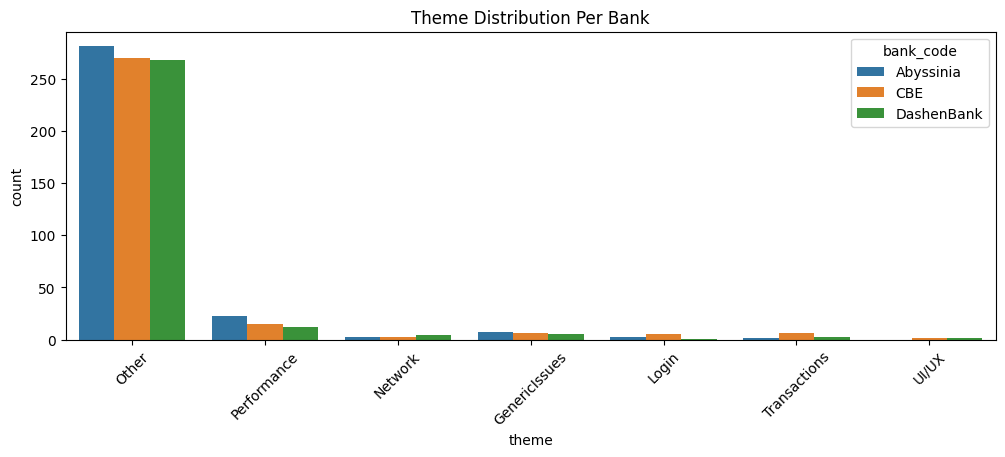

In [16]:
plt.figure(figsize=(12, 4))

sns.countplot(data=df, x="theme", hue="bank_code")
plt.title("Theme Distribution Per Bank")
plt.xticks(rotation=45)
plt.show()


Observation: “Other” Became the Largest Theme

This happened because:

(a) Theme keyword lists were too narrow

Only a small number of nouns (e.g., crash, login, transfer) matched the limited lists, while most real nouns like:

issue

service

feature

error

update

option

device

problem

did not map to any existing theme.

(b) Only nouns were used

Important verbs and adjectives like:

loading

failed

crashing

not opening

slow

updating

were lost since our extraction pipeline focused only on nouns.

(c) Different banks use different wording

Example:

“connection” ≠ “network”

“device” ≠ “phone”

“service issue” ≠ “service”
These mismatches led to more “Other” classifications.

(d) TF-IDF keywords were not integrated into theme mapping

We extracted TF-IDF per bank but did not use them to refine themes.

In [17]:
df.to_csv(DATA_PATHS["sentiment_results"], index=False)
df.to_csv(DATA_PATHS["final_results"], index=False)

print("Saved:")
print(" - Sentiment Results:", DATA_PATHS["sentiment_results"])
print(" - Final Results    :", DATA_PATHS["final_results"])


Saved:
 - Sentiment Results: ../data/processed/reviews_with_sentiment.csv
 - Final Results    : ../data/processed/reviews_final.csv


In [18]:
df.head(10)


,review_id,review_text,clean_text,tokens,rating,review_date,review_year,review_month,bank_code,bank_name,...,thumbs_up,text_length,source,tb_polarity,tb_subjectivity,tb_sentiment,vader_compound,vader_sentiment,nouns,theme
0,843256e6-6275-4ae5-adaf-a01889b8a49f,Make the reason we wrote visible on app transa...,make reason wrote visible app transaction,"['make', 'reason', 'wrote', 'visible', 'app', ...",2,2025-12-01,2025,12,Abyssinia,Bank of Abyssinia,...,0,52,Google Play,0.000000,0.000000,neutral,0.0000,neutral,"[reason, app, transaction]",Other
1,60e84fba-4730-499d-8f5b-88e52dda8db7,app is note active working crash,app note active working crash,"['app', 'note', 'active', 'working', 'crash']",1,2025-11-30,2025,11,Abyssinia,Bank of Abyssinia,...,0,32,Google Play,-0.133333,0.600000,negative,0.0000,neutral,"[working, crash]",Other
2,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,NaN,[],5,2025-11-29,2025,11,Abyssinia,Bank of Abyssinia,...,0,2,Google Play,0.000000,0.000000,neutral,0.0000,neutral,[],Other
3,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,good,['good'],5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,...,0,9,Google Play,0.910000,0.780000,positive,0.4927,positive,[],Other
4,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,goof,['goof'],5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,...,0,4,Google Play,0.000000,0.000000,neutral,0.0000,neutral,[goof],Other
5,11306fb9-5571-4950-8d32-604c5402242f,good!,good,['good'],5,2025-11-28,2025,11,Abyssinia,Bank of Abyssinia,...,0,5,Google Play,0.875000,0.600000,positive,0.4926,positive,[],Other
6,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,good jop,"['good', 'jop']",5,2025-11-27,2025,11,Abyssinia,Bank of Abyssinia,...,0,8,Google Play,0.700000,0.600000,positive,0.4404,positive,[jop],Other
7,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,bad exprience crushed,"['bad', 'exprience', 'crushed']",1,2025-11-27,2025,11,Abyssinia,Bank of Abyssinia,...,0,32,Google Play,-0.400000,0.383333,negative,-0.7973,negative,[exprience],Other
8,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,user friendly requires huge connectivity also ...,"['user', 'friendly', 'requires', 'huge', 'conn...",1,2025-11-26,2025,11,Abyssinia,Bank of Abyssinia,...,0,85,Google Play,0.425000,0.633333,positive,-0.4268,negative,"[user, connectivity, times]",Performance
9,896ee9aa-a483-4b1f-b73c-0a26c4b54790,most of the time is not working properly,time working properly,"['time', 'working', 'properly']",1,2025-11-25,2025,11,Abyssinia,Bank of Abyssinia,...,0,40,Google Play,0.250000,0.300000,positive,0.0000,neutral,[time],Other


The large size of “Other” indicates that the initial theme dictionary was:

too narrow

missing many high-frequency nouns

not adaptive to bank-specific language

not leveraging TF-IDF results

limited by noun-only extraction

✔️ Next Step

To improve theme accuracy, the theme dictionary should be:

expanded using actual dataset nouns

augmented using TF-IDF per bank

enhanced with verbs and adjectives (e.g., failing, crashing, loading)

refined with LDA topic modeling for automatic theme discovery

This will significantly reduce the “Other” category and provide a clearer thematic breakdown per bank.